### Let's get started:

# Step 0: Data source

The data source comes from kaggle's user BwandoWando. And you can find it here: https://www.kaggle.com/discussions/accomplishments/514061
It consists of a collection of National Oceanic and Atmospheric Administration. The data available varies from Maritime Mobile Service Identity (MMSI) to MMSI, so I just focused on the basics ('LAT', 'LON', 'SOG', 'COG', 'Heading') for a consistent application.

## Step 0.1: PRE-Preprocessing, Ignore for now.

For preprocessing I split the data into MSSI cases for a lighter computing workload. For a deeper version I would use multiple vessels to improve performance as well as to decrease bias.

import os
list1 = [129129903, 209920000,212259000,215567000,241454000]
for x in list1:
    j = 0
    for root, dirs, files in os.walk("/Volumes/KINGSTON/Personal Works/Doctoral Thesis Point 1/Data/", topdown=False):
        i = 0
        for name in files:
            df1 = pd.read_parquet(os.path.join(root, name), engine='pyarrow')
            df1 = df[df.MMSI == x]
            #del(df)
            if i == 0:
                df2 = df1.copy()
            else:
                df2 = pd.concat([df2, df1])
            i = i + 1
            del(df1)  
        df2.to_csv("2023_AIS_Vessel_" + str(x) + ".csv")
    if j == 0:
        df_all = df2.copy()
    else:
        df_all = pd.concat([df_all, df2])
    j = j + 1
df_all.to_csv("2023_AIS_Vessel_all.csv")

# Step 1: Requirements

Read libraries, set random seeds to get reproducibility and print main libraries versions for version clarity

In [9]:
# Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go


# Reproducibility
SEED = 13
tf.random.set_seed(SEED)
TRAIN_SPLIT = 30000

#Print main libraries version
print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

Tensorflow Version: 2.16.2
Pandas Version: 2.2.2
Numpy Version: 1.26.4
System Version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


In [10]:
# Count execution time to determine training time
notebookstart= time.time()

# Step 2: Data prep

The data is subset into just our interested features.

Samples are restricted to one per hour for consistency and for less noise. 

Missing values are dropped.

In [13]:
df = pd.read_csv('2023_AIS_Vessel_209920000.csv', engine='pyarrow')
df.drop_duplicates(subset = ['BaseDateTime'], inplace = True)

In [14]:
# Series of hours that span the range of the Index
s = pd.Series(pd.date_range(df.BaseDateTime.min().floor('H'), df.BaseDateTime.max().ceil('H'), freq='H'),
              name='times').astype('datetime64[s]')
 
df1 = pd.merge_asof(s, df.sort_values('BaseDateTime'), left_on='times', right_on='BaseDateTime', direction='nearest')

features = df1[['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading']]
features.index = df1['BaseDateTime']

# Drop nans to avoid null metrics
features.dropna(how = "any", inplace = True)

/var/folders/1c/7zvkcxvj2d52lgxzk8tfs1w00000gn/T/ipykernel_30564/2535658143.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = pd.Series(pd.date_range(df.BaseDateTime.min().floor('H'), df.BaseDateTime.max().ceil('H'), freq='H'),
/var/folders/1c/7zvkcxvj2d52lgxzk8tfs1w00000gn/T/ipykernel_30564/2535658143.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(how = "any", inplace = True)


## Step 2.1 Normalize data to equal the impact of each feature

In [17]:
# Select relevant features
features = ['LAT', 'LON', 'SOG', 'COG', 'Heading']
target = ['LAT', 'LON', 'SOG', 'COG', 'Heading']  # Predict next latitude & longitude

# Define sliding window function
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])  # Sequence of inputs
        y.append(target[i + seq_length])  # Next step as output
    return np.array(X), np.array(y)

# Define sequence length
SEQ_LENGTH = 10

# Create input-output pairs
X, y = create_sequences(df[features].dropna().values, df[target].dropna().values, SEQ_LENGTH)

# Split into train, validation & test sets (0.6, 0.2, 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

# 3. Custom functions

In [20]:
### 4.1 Custom loss function
# Haversine Distance Function using numpy
def haversine_loss(y_true, y_pred):
    # Convert degrees to radians using numpy
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    lat1, lon1, speed1, course1, heading1 = tf.split(y_true, 5, axis=-1)
    lat2, lon2, speed2, course2, heading2 = tf.split(y_pred, 5, axis=-1)
    
    lat1 = lat1 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lon1 = lon1 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lat2 = lat2 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lon2 = lon2 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = tf.sin(dlat / 2.0) ** 2 + tf.cos(lat1) * tf.cos(lat2) * tf.sin(dlon / 2.0) ** 2
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    radius = 6371.0  # Earth's radius in kilometers
    haversine_distance = radius * c
    return tf.reduce_mean(haversine_distance)
    
# Combined Loss Function
def combined_loss(y_true, y_pred):
    haversine = haversine_loss(y_true, y_pred) 
    mse = tf.reduce_mean(tf.math.square(y_true - y_pred))
    return 0.1 * mse + 0.9 * haversine

### 4.2 Custom metrics
def cumulative_geospatial_error(y_true, y_pred):
    # Convert degrees to radians using numpy
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
 
    lat1, lon1, speed1, course1, heading1 = tf.split(y_true, 5, axis=-1)
    lat2, lon2, speed2, course2, heading2 = tf.split(y_pred, 5, axis=-1)
    
    lat1 = lat1 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lon1 = lon1 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lat2 = lat2 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
    lon2 = lon2 * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = tf.sin(dlat / 2.0) ** 2 + tf.cos(lat1) * tf.cos(lat2) * tf.sin(dlon / 2.0) ** 2
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    radius = 6371.0  # Earth's radius in kilometers
    haversine_distance = radius * c
    return tf.reduce_sum(haversine_distance)

def Consistency(y_true, y_pred):
    # Convert degrees to radians using numpy
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    lat1, lon1, speed1, course1, heading1 = tf.split(y_true, 5, axis=-1)
    lat2, lon2, speed2, course2, heading2 = tf.split(y_pred, 5, axis=-1)
        
    absolute_error = tf.abs(course1-course2) 
    return tf.reduce_mean(absolute_error)

## 4. Modeling the data

In [23]:
modelstart = time.time()
early_stopping = EarlyStopping(monitor="loss", patience = 10, restore_best_weights=True)

# Define LSTM Model
model = Sequential([
    Input(shape=(SEQ_LENGTH, len(features))),  
    LSTM(128, activation='tanh', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),  # Last LSTM layer outputs a single vector
    Dense(5)  # Predict next (LAT, LON)
])


# Compile the model with Nadam optimizer
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-6, clipvalue=1.0),
    loss=combined_loss,
    metrics=[haversine_loss, cumulative_geospatial_error, Consistency]
)
print(model.summary())

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

model.save('multi-output-timesteps.keras')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Epoch 1/20
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - consistency: 174.9691 - cumulative_geospatial_error: 165490.0469 - haversine_loss: 10343.1299 - loss: 11015.4590 - val_consistency: 173.1501 - val_cumulative_geospatial_error: 164532.2344 - val_haversine_loss: 10283.2646 - val_loss: 10935.8154
Epoch 2/20
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - consistency: 174.8710 - cumulative_geospatial_error: 164639.6250 - haversine_loss: 10289.9785 - loss: 10965.1035 - val_consistency: 173.0421 - val_cumulative_geospatial_error: 163605.7656 - val_haversine_loss: 10225.3604 - val_loss: 10881.2510
Epoch 3/20
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - consistency: 174.7598 - cumulative_geospatial_error: 163670.4688 - haversine_loss: 10229.4062 - loss: 10908.1094 - val_consistency: 172.9202 - val_cumulative_geospatial_error: 162434.2344 - val_haversine_loss: 10152.1396 - val_loss: 10812.5928
Epoch 4/20
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - consistency: 174.6343 - cumulative_geosp

## 4. Predictions and Evaluation

In [32]:
prediction = model.predict(X_test)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [77]:
# Combined loss for test data
haversine = haversine_loss(y_test, prediction).numpy()
mse = tf.reduce_mean(tf.math.square(y_test - prediction))
print("The combined loss for the test data is ", (0.1 * mse + 0.9 * haversine).numpy())

# Evaluations for test data
haversine = haversine_loss(y_test, prediction).numpy()
print("The harvesine loss for the test data is ", haversine)
print("The geospatial loss for the test data is ", cumulative_geospatial_error(y_test, prediction).numpy())
print("The Consistency loss for the test data is ", Consistency(y_test, prediction).numpy())

The combined loss for the test data is  1638.1918355494176
The harvesine loss for the test data is  761.7693
The geospatial loss for the test data is  6276979.0
The Consistency loss for the test data is  105.77431


In [34]:
# Denormalize values before computation
true = pd.DataFrame(y_test[:,:2], columns=["true_lat", "true_lon"])
pred = pd.DataFrame(prediction[:,:2], columns=["pred_lat", "pred_lon"])
df_pred = pd.concat([true, pred], axis = 1)

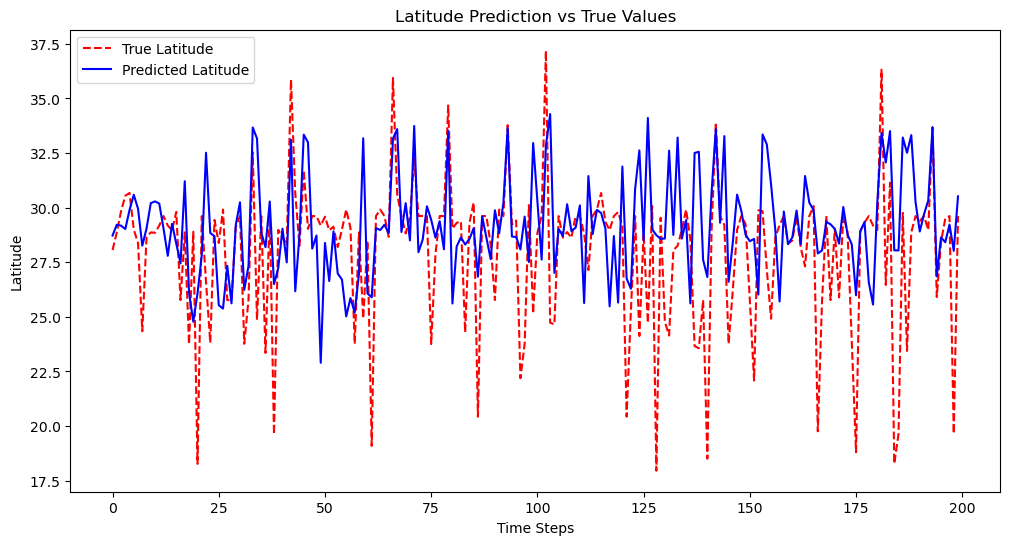

In [153]:
plt.figure(figsize=(12, 6))

# Plot latitude over time
plt.plot(df_pred.true_lat[:200], label="True Latitude", color='red', linestyle='dashed')
plt.plot(df_pred.pred_lat[:200], label="Predicted Latitude", color='blue', linestyle='solid')

plt.xlabel("Time Steps")
plt.ylabel("Latitude")
plt.title("Latitude Prediction vs True Values")
plt.legend()
plt.savefig("Latitude.png")
plt.show()

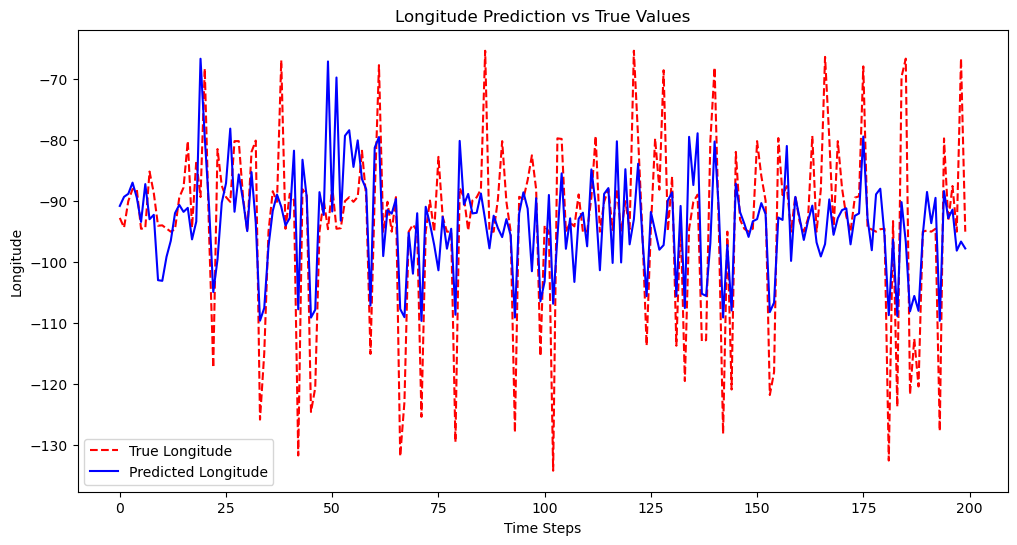

In [155]:
plt.figure(figsize=(12, 6))

# Plot latitude over time
plt.plot(df_pred.true_lon[:200], label="True Longitude", color='red', linestyle='dashed')
plt.plot(df_pred.pred_lon[:200], label="Predicted Longitude", color='blue', linestyle='solid')

plt.xlabel("Time Steps")
plt.ylabel("Longitude")
plt.title("Longitude Prediction vs True Values")
plt.legend()
plt.savefig("Longitude.png")
plt.show()

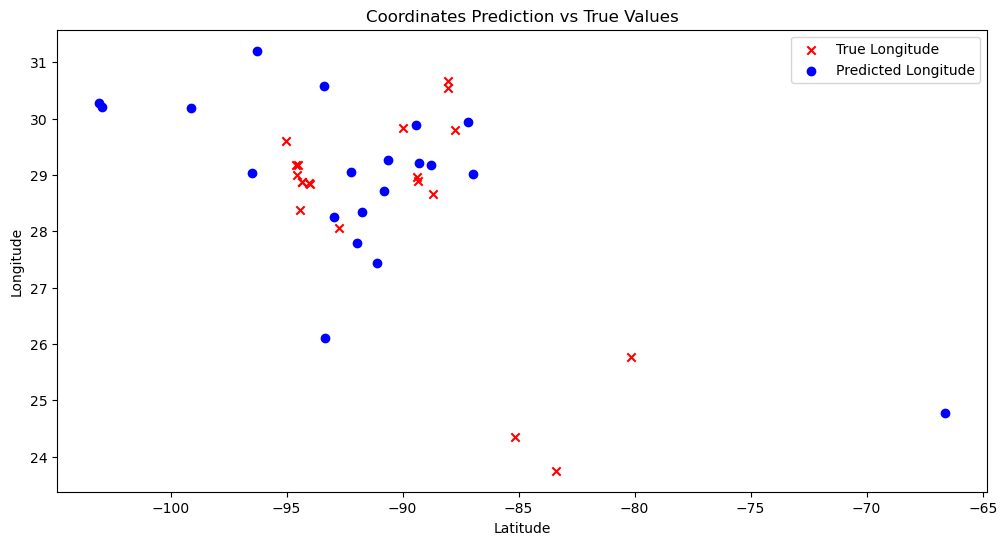

In [93]:
plt.figure(figsize=(12, 6))

# Plot latitude over time
plt.scatter(df_pred.true_lon[:20], df_pred.true_lat[:20], label="True Longitude", color='red', marker='x')
plt.scatter(df_pred.pred_lon[:20], df_pred.pred_lat[:20], label="Predicted Longitude", color='blue', marker = 'o')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Coordinates Prediction vs True Values")
plt.legend()
plt.show()

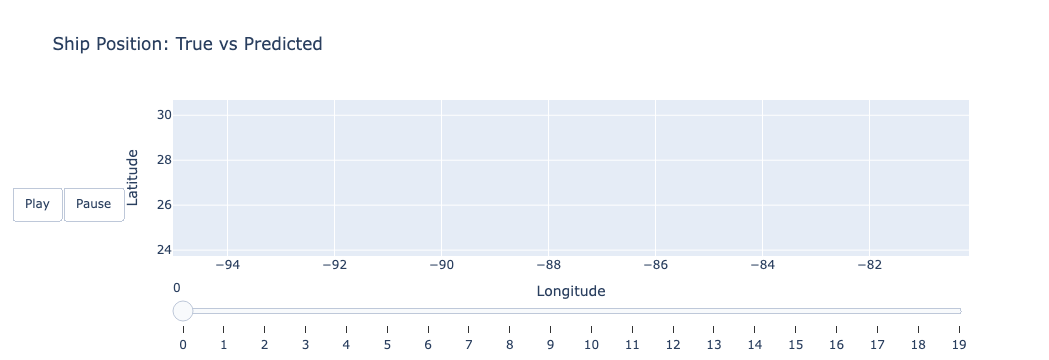

In [137]:
# Sample data (replace with df_pred)
df = df_pred[:20].copy()
num_frames = len(df)

# Create figure
fig = go.Figure()

# Add initial frame (empty)
fig.add_trace(go.Scatter(
    x=[], y=[], mode='markers', marker=dict(color='red', size=8), name="True Position"
))
fig.add_trace(go.Scatter(
    x=[], y=[], mode='markers', marker=dict(color='blue', size=8), name="Predicted Position"
))

# Define animation frames (only current frame's points)
frames = [
    go.Frame(
        data=[
            go.Scatter(x=[df["true_lon"][k]], y=[df["true_lat"][k]], mode='markers',
                       marker=dict(color='red', size=10)),  # True position
            go.Scatter(x=[df["pred_lon"][k]], y=[df["pred_lat"][k]], mode='markers',
                       marker=dict(color='blue', size=10))  # Predicted position
        ],
        name=str(k)
    )
    for k in range(num_frames)
]

# Update figure layout with slider
fig.update_layout(
    title="Ship Position: True vs Predicted",
    xaxis_title="Longitude",
    yaxis_title="Latitude",
    xaxis=dict(range=[df["true_lon"].min() - 0.01, df["true_lon"].max() + 0.01]),
    yaxis=dict(range=[df["true_lat"].min() - 0.01, df["true_lat"].max() + 0.01]),
    updatemenus=[
        {
            "buttons": [
                {"args": [None, {"frame": {"duration": 200, "redraw": True}, "fromcurrent": True}],
                 "label": "Play", "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0}, "mode": "immediate", "redraw": True}],
                 "label": "Pause", "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons"
        }
    ],
    sliders=[{
        "active": 0,
        "steps": [
            {"args": [[str(k)], {"frame": {"duration": 0}, "mode": "immediate", "redraw": True}],
             "label": str(k), "method": "animate"}
            for k in range(num_frames)
        ]
    }]
)

# Assign frames properly
fig.frames = frames

# Show plot
fig.show()